<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/ARMA%E5%AE%9F%E8%A3%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARMAモデル

自己回帰移動平均モデルと呼ばれ、MAモデルとARモデルを組み合わせたモデルである。

次数：p
次数：q



### MAモデル　p

移動平均モデル。「将来のYは過去の誤差によって説明される」
　「将来の予測値は、過去の予測値と実績値との誤差により決まる」

例えば、今月の売上量が、本来売上げる量より多かったら、来月は売上量が増える

次数：<font color="red">q</font>

過去どれだけ遡ると良くなるのかを試行する。

### ARモデル　q


自己回帰　「将来のYは、過去のYによって説明される」

「将来の予測値は、過去の予測値により決まる」、

例えば、今月の売上量が多かったら、来月は売上量が増える

次数：p

## データの読み込みと整形、分割まで

今回使用するデータは、気温の時系列データです。

データ配布元：http://www.data.jma.go.jp/gmd/risk/obsdl/index.php

**まずは、理解を容易にするため、気温データのみを用います**

In [ ]:
import pandas as pd
weather_df = pd.read_csv("/content/weather (1).csv", encoding="shift-jis")

In [ ]:
weather_df.head(5)

,年月日,平均気温(℃),降水量の合計(mm),平均風速(m/s),日照時間(時間),平均現地気圧(hPa)
0,2015/1/1,3.7,0.0,4.4,1.3,1000.4
1,2015/1/2,2.7,0.0,2.1,6.0,1007.4
2,2015/1/3,3.8,0.0,3.0,8.9,1012.0
3,2015/1/4,4.0,0.0,1.3,6.0,1010.4
4,2015/1/5,6.9,0.0,2.4,8.9,1014.6


#### データ整形

In [ ]:
# 今回は練習の為、"年月日"と"平均気温(℃)"のカラムのみ使用致します。このようにしますと、任意のカラムのみ抽出する事が出来ます。

weather_df = weather_df[["年月日","平均気温(℃)"]]   # []を二重に
weather_df.head(5)

,年月日,平均気温(℃)
0,2015/1/1,3.7
1,2015/1/2,2.7
2,2015/1/3,3.8
3,2015/1/4,4.0
4,2015/1/5,6.9


In [ ]:
weather_df.info()
# weather_df.dtype()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   年月日      1827 non-null   object 
 1   平均気温(℃)  1827 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.7+ KB


In [ ]:
# weather_df["年月日"]をdatetimeに変換した後、indexに格納します。
# それが完了したらカラムの["年月日"]はいらないのでドロップしましょう。
weather_df.index = pd.to_datetime(weather_df["年月日"], infer_datetime_format=True) 
weather_df = weather_df.drop(columns = ["年月日"])
weather_df.head(5)

# 上記のコードはこういうものなんだと割り切って頂ければ。

,平均気温(℃)
年月日,
2015-01-01,3.7
2015-01-02,2.7
2015-01-03,3.8
2015-01-04,4.0
2015-01-05,6.9


In [ ]:
data = weather_df.resample("M").mean()
# data = weather_df.resample("W").mean() #⇒こうすれば1週間ごとになります。　お好みで。

data

,平均気温(℃)
年月日,
2015-01-31,5.783871
2015-02-28,5.717857
2015-03-31,10.251613
2015-04-30,14.523333
2015-05-31,21.100000
...,...
2019-09-30,25.060000
2019-10-31,19.425806
2019-11-30,13.100000


### 訓練データ・テストデータの分割
5対5で。



In [ ]:
# データ数(len)*0.5をintに変換 その後に：で範囲を指定。 lenとintとlistの複合技です。

train=data[:int(len(data)*0.5)] # この長さまで。
test=data[int(len(data)*0.5):] # この長さ以降。

In [ ]:
train

,平均気温(℃)
年月日,
2015-01-31,5.783871
2015-02-28,5.717857
2015-03-31,10.251613
2015-04-30,14.523333
2015-05-31,21.100000
2015-06-30,22.090000
2015-07-31,26.248387
2015-08-31,26.674194
2015-09-30,22.586667


## モデル作成と確認

AR/ARMAモデルをそれぞれ作成する　ここから先ほどのARモデルと違ってきます。

### 学習と精度評価　1回目

In [ ]:
from statsmodels.tsa.arima_model import ARMA
model_arma = ARMA(train, order=[1, 1])  # 学習データを食べさせる。そしてpとqも指定。
# モデルの学習
result_arma = model_arma.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


学習したモデルがどうなのか、可視化して確認してみましょう。

その為にpredを求めます。

In [ ]:
test

,平均気温(℃)
年月日,
2017-07-31,27.319355
2017-08-31,26.448387
2017-09-30,22.806667
2017-10-31,16.825806
2017-11-30,11.943333
2017-12-31,6.635484
2018-01-31,4.654839
2018-02-28,5.353571
2018-03-31,11.461290


In [ ]:
# 予測⇒どの期間を予測するのかはtest_yで確認。⇒日付だけはtestとpred双方とも合致していると確認しましょう。
pred = result_arma.predict("2017-07-31","2020-01-31")

print(test.head(5))
print()
print(pred.head(5))

              平均気温(℃)
年月日                  
2017-07-31  27.319355
2017-08-31  26.448387
2017-09-30  22.806667
2017-10-31  16.825806
2017-11-30  11.943333

2017-07-31    21.671244
2017-08-31    20.389767
2017-09-30    19.377232
2017-10-31    18.577197
2017-11-30    17.945064
Freq: M, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


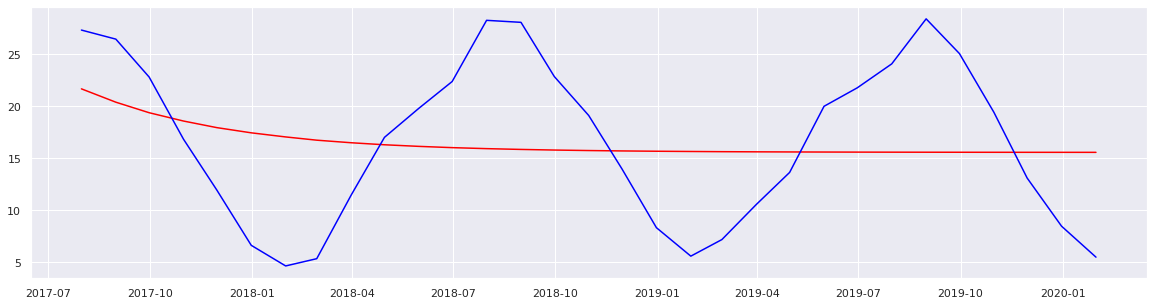

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(20,5))

#1つ目のデータをplotメソッドでプロット
plt.plot(pred, color = 'red',label="pred")

#2つ目のデータをplotメソッドでプロット
plt.plot(test, color = 'blue',label="acutual")
plt.show()

観たらわかる。全く上手く行ってませんね。どうすればよいでしょうか？

きっとパラメータ設定がおかしいのでしょう。この部分を調整して確認しましょう。


```
model_arma = ARMA(train, order=[1, 1])
```




### 学習と精度評価　2回目

ARMAモデルのパラメータ調整に使えるパラメータがありますので、その通りに実装してみてください。

何をしているかって？　<font color="red">グリッドサーチ</font>です。自動で最良のパラメータを探して提示してくれる便利なツールです。

In [ ]:
# pとqの自動更新ライブラリ

from statsmodels.tsa.stattools import arma_order_select_ic

#arがp maがq ⇒ 最大を指定。⇒大体この位で良いものです。時間もかかるし。
arma_order_select_ic(train, max_ar=4, max_ma=4, ic='aic')

# 出力結果を確認し、良いパラメータにて再学習しましょう。
# しかし、表示された値が最良でない場合も多々あります。その際はその周辺を確認してください。

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available',

{'aic':             0           1           2           3           4
 0  207.444269  179.190590  159.487359  154.006158  154.425123
 1  172.418180  159.814397  151.074279  149.945585  148.523382
 2  135.957280  142.687188  111.554688  110.567281  146.275305
 3  127.588670  115.236184  114.071543  112.467741  124.130148
 4  125.763298  114.894459  117.737496  116.321206  115.043116,
 'aic_min_order': (2, 3)}

In [ ]:
test.head(3)

,平均気温(℃)
年月日,
2017-07-31,27.319355
2017-08-31,26.448387
2017-09-30,22.806667


In [ ]:
from statsmodels.tsa.arima_model import ARMA
model_arma = ARMA(train, order=[1, 2])  # 学習データを食べさせる。そしてpとqも指定。
# モデルの学習
result_arma = model_arma.fit()

In [ ]:
# 予測⇒どの期間を予測するのかはtest_yで確認。⇒日付だけはtestとpred双方とも合致していると確認しましょう。
pred = result_arma.predict("2017-07-31","2020-01-31")

print(test.head(5))
print()
print(pred.head(5))

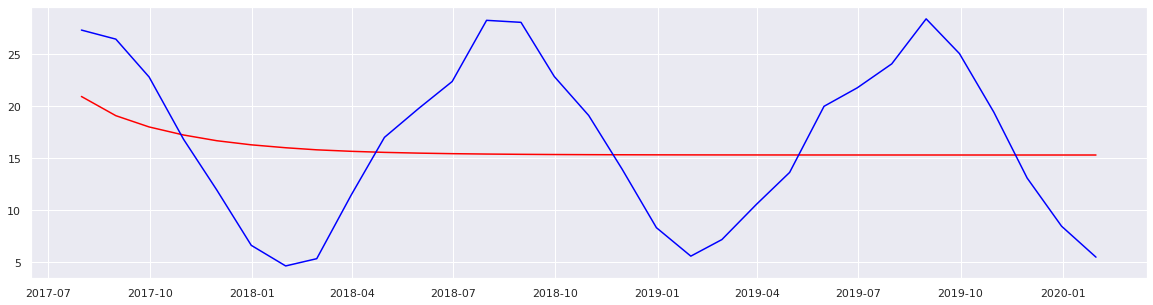

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(20,5))

#1つ目のデータをplotメソッドでプロット
plt.plot(pred, color = 'red',label="pred")

#2つ目のデータをplotメソッドでプロット
plt.plot(test, color = 'blue',label="acutual")
plt.legend()
plt.show()

# 別のモジュールを用いてARMAを予測
[これが参考colab](https://colab.research.google.com/drive/1dfFfrMthALaICyI-tydWfJGjbroUqTnt#scrollTo=GAFQVK0ljIQY)

⇒上手く行かなかった。

In [ ]:
#いろいろインポート
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# AR/ MA/ ARMAモデルの予測用モジュールのインポート
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm 

In [ ]:
#データの確認
data.head(4)
train.head(4)
test.head(4)

,平均気温(℃)
年月日,
2017-07-31,27.319355
2017-08-31,26.448387
2017-09-30,22.806667
2017-10-31,16.825806


学習

In [ ]:
y = data["平均気温(℃)"]#予測したいもの。データを格納。
# Dはなんでしたっけ？⇒ freq="D"　一日毎　daysのD　monthのM
arma_model = sm.tsa.ARMA(y, order=(2,1),freq="M")
result = arma_model.fit()

result.summary()

ValueError: ignored